<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_1/ds_mod1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto da análise

A COVID-19 já causou mais de 3,5 milhões de mortos no mundo. E quase 500 mil mortes oficiais somente no Brasil. No final do ano de 2020, as primeiras vacinas começaram a serem aplicadas no mundo. A Inglaterra, inciou sua vacinação em 8 de dezembro de 2020[1]. E hoje tem cerca de 37% da população completamente vacinada[2]. No Brasil, a vacinação começou em 17 de janeiro de 2021[3].

Neste projeto será observado o impacto da vacinação de COVID-19 no número de internações para SRAG (Síndrome Respiratória Aguda Grave).

[1] - https://www.cnnbrasil.com.br/internacional/2020/12/08/britanica-de-90-anos-e-primeira-a-receber-a-vacina-da-pfizer-fora-dos-testes

[2] - https://coronavirus.data.gov.uk/details/vaccinations

[3] - https://www.cnnbrasil.com.br/nacional/2021/01/17/primeira-pessoa-e-vacinada-contra-covid-19-no-brasil

# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install isoweek
from isoweek import Week

## Coleta de dados

## Dados de Vacinação

Será utilizado os dados de vacinação da COVID-19 disponibilizados pelo SUS, através do portal OpendataSUS[1].

Os dados foram extraídos em 23/05/2021. Tem 28.5 GB de tamanho.

Abaixo, apenas as 10 primeiras linhas do documento original.

[1] -  https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8

In [3]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/dados_originais_head.csv" .
pd.read_csv("/content/dados_originais_head.csv", encoding="ISO-8859-1", sep=";").head()

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,paciente_endereco_nmpais,paciente_endereco_uf,paciente_endereco_cep,paciente_nacionalidade_enumnacionalidade,estabelecimento_valor,estabelecimento_razaosocial,estalecimento_nofantasia,estabelecimento_municipio_codigo,estabelecimento_municipio_nome,estabelecimento_uf,vacina_grupoatendimento_codigo,vacina_grupoatendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem
0,d69492e7-2c28-4892-9aac-0a378206c968-i0b0,7518e34074e7262958c5ca15dddf901de351c253565ee1...,77,1943-09-03,M,1,BRANCA,420480,10,CURITIBANOS,BRASIL,SC,89520,B,2302438,PREFEITURA MUNICIPAL DE CURITIBANOS,POSTO DE ATEND MATERNO INFANTIL,420480,CURITIBANOS,SC,0,NaN,NaN,NaN,210068,SERUM INSTITUTE OF INDIA LTD,NaN,2021-03-20,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,ESUS APS - NACIONAL (OFFLINE),2021-03-24T12:31:25.000Z,NaN
1,00008936-722c-4329-a8f8-49f914c14231-i0b0,fa0290484b076c2b4df18119863be049cf6ebd9690184e...,77,1944-02-21,M,3,PARDA,110020,10,PORTO VELHO,BRASIL,RO,76820,B,213241,MUNICIPIO DE PORTO VELHO,CENTRAL DE REDE DE FRIO PORTO VELHO,110020,PORTO VELHO,RO,204,Pessoas de 75 a 79 anos,2.0,Faixa EtÃ¡ria,210017,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-23,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-23T12:59:53.000Z,NaN
2,5af902c3-caff-4a1a-8c8e-efd78c71fb73-i0b0,8e37fba588e2e90a219427b9a5d9c58127a73eb8b4df90...,75,1945-04-10,M,1,BRANCA,510675,10,PONTES E LACERDA,BRASIL,MT,78250,B,2394456,PREFEITURA MUNICIPAL DE PONTES E LACERDA,CENTRO DE SAUDE DE PONTES E LACERDA,510675,PONTES E LACERDA,MT,301,Pessoas de 60 nos ou mais Institucionalizadas,3.0,Pessoas de 60 anos ou mais institucionalizadas,210086,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-30,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-04-03T13:07:42.000Z,NaN
3,7fa5874c-7bf6-47ba-ab4b-50a95d8ee472-i0b0,11220f7797eb222c83c82fbff09d2af82aebc6ddab6c6b...,90,1930-06-13,F,1,BRANCA,330100,10,CAMPOS DOS GOYTACAZES,BRASIL,RJ,28051,B,6298109,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,330100,CAMPOS DOS GOYTACAZES,RJ,205,Pessoas de 80 anos ou mais,2.0,Faixa EtÃ¡ria,210011A,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-18,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-17T19:47:19.000Z,NaN
4,5afa5eab-1fd1-4c36-91bf-8b098c5ee3ab-i0b0,af81199ba8994176baeaecbc4a2b7d3ad71d3432b765b2...,64,1957-03-25,F,3,PARDA,280030,10,ARACAJU,BRASIL,SE,49044,B,2550,SECRETARIA MUNICIPAL DE SAUDE DE ARACAJU,US ELIZABETE PITA TERRA DURA,280030,ARACAJU,SE,201,Pessoas de 60 a 64 anos,2.0,Faixa EtÃ¡ria,CTMAV505,FUNDACAO OSWALDO CRUZ,NaN,2021-04-07,Â Â Â Â 1ÂªÂ Dose,85,Vacina Covid-19 - Covishield,IDS SaÃºde,2021-04-07T11:13:09.000Z,NaN


Como a base original contém informações que não serão utilizadas nesta análise, extraí apenas as colunas que serão utilizadas. E realizei um trabalho de eliminar caracteres desnecessários (como aspas duplas) e simplificar informações como a dose aplicada de "Â Â Â Â 1ÂªÂ Dose" para 1 ou 2, de acordo com a dose aplicada.

Resultando em 2.8GB. Este arquivo tem 57.442.714 linhas.

Abaixo, o comando usado localmente para extrair as colunas e limpar os dados.
```
cut part-00000-6bab261e-57eb-41e1-9523-8487c4a7c57c-c000.csv -d ";" -f3,5,7,12,20,26,28,29 | sed 's/"//g' | sed -E 's/    ([12]).*/\1/g' > vaccines_v2.csv
```


### *Amostragem*

A base de dados ainda está muito grande para ser trabalhada livremente. Então, foi extraído 0.1% dos dados da base original e armazenados em uma base de dados menor, a fim de facilitar a manipulação dos dados.

In [4]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/sample_1percent.csv" .
dados = pd.read_csv("/content/sample_1percent.csv", encoding="ISO-8859-1", sep=",")

dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1


## Dados de Internação

Os dados de internações de SRAG foram coletados do portal OpendataSUS[1].

Os dados foram extraídos em 28/05/2021. Tem 453 MB de tamanho.

Abaixo, apenas as 10 primeiras linhas do documento original.

[1] - https://opendatasus.saude.gov.br/dataset/bd-srag-2021/resource/42bd5e0e-d61a-4359-942e-ebc83391a137

In [5]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/internacoes_head.csv" .
pd.read_csv("/content/internacoes_head.csv", encoding="ISO-8859-1", sep=";").head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,...,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA
0,05/01/2021,1,04/01/2021,1,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380,SALVADOR,292740,HOSPITAL DO SUBURBIO,6595197,F,19/08/1974,46,3,3046,5,9,NaN,NaN,BRASIL,1,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380,SALVADOR,292740,1.0,2.0,1.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2,2.0,2.0,...,2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04/01/2021,1,04/01/2021,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HOSPITAL KATIA DE SOUZA RODRIGUES TAIPAS SAO P...,2082225,M,26/10/2020,3,2,2003,6,1,NaN,NaN,BRASIL,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,1.0,2.0,2.0,2.0,1,1.0,2.0,2.0,1.0,2.0,2,2.0,2.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,04/01/2021,1,03/01/2021,1,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950,HOSPITAL E MATERNIDADE CELSO PIERRO,2082128,F,11/01/1936,84,3,3084,5,1,NaN,9.0,BRASIL,1,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950,1.0,2.0,2.0,2.0,1,1.0,2.0,2.0,1.0,1.0,2,2.0,1.0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04/01/2021,1,03/01/2021,1,SP,GVE XXVII SAO JOSE DOS CAMPOS,1351,SAO JOSE DOS CAMPOS,354990,DR RUBENS SAVASTANO HOSPITAL REGIONAL DE SAO J...,9491252,M,08/10/1955,65,3,3065,6,4,NaN,NaN,BRASIL,1,SP,GVE XXVII SAO JOSE DOS CAMPOS,1351,JACAREI,352440,NaN,NaN,NaN,NaN,2,2.0,2.0,1.0,1.0,1.0,2,2.0,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08/01/2021,1,07/01/2021,1,PR,09RS FOZ DO IGUACU,1363,FOZ DO IGUACU,410830,HOSPITAL MUNICIPAL PADRE GERMANO LAUCK,5061989,M,26/01/2004,16,3,3016,6,4,NaN,9.0,BRASIL,1,PR,09RS FOZ DO IGUACU,1363,FOZ DO IGUACU,410830,1.0,2.0,2.0,2.0,1,1.0,1.0,1.0,1.0,1.0,2,2.0,1.0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apenas as colunas DT_NOTIFIC, CS_SEXO e  NU_IDADE_N serão utilizadas

```
cut INFLUD21-24-05-2021.csv -d ";" -f 1,12,14 | sed 's/"//g' > internacoes_24052021.csv
```

In [6]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/internacoes_24052021.csv" .
internacoes = pd.read_csv("/content/internacoes_24052021.csv", encoding="ISO-8859-1", sep=";")

internacoes.head()

,DT_NOTIFIC,CS_SEXO,NU_IDADE_N
0,05/01/2021,F,46
1,04/01/2021,M,3
2,04/01/2021,F,84
3,04/01/2021,M,65
4,08/01/2021,M,16


# Exploração inicial

Exploração inicial para visualizar e entender como estão distribuídos os dados.

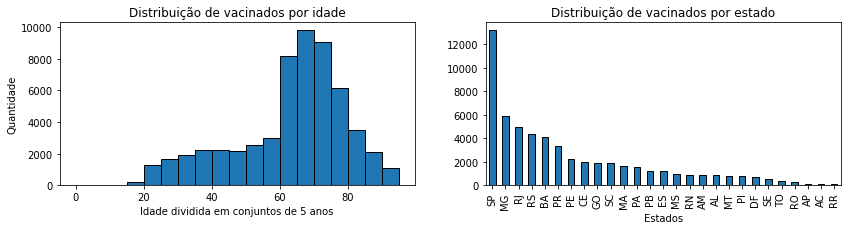

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,3))

# Tem uma pessoa com 221 anos!
ax = dados['paciente_idade'].plot(kind='hist', bins=[x for x in range(0,100,5)],
                             edgecolor='black', ax=axes[0],
                             title="Distribuição de vacinados por idade")
ax.set_ylabel("Quantidade")
ax.set_xlabel("Idade dividida em conjuntos de 5 anos")
ax = dados['estabelecimento_uf'] \
  .value_counts().plot(kind='bar',  ax=axes[1], edgecolor='black',
                       title="Distribuição de vacinados por estado")
ax.set_xlabel("Estados")
plt.show()

Com os gráficos acima, é possível ver a vacinação avançando na população prioritária, como idosos. No gráfico a direita, vemos os números absolutos por estado. São Paulo, como mais populoso, tem a maior quantidade de vacinados.

Vale ressaltar que, como este data set é apenas 0.1% do original, então o valor real das quantidades é mil vezes maior.

In [8]:
dados['vacina_fabricante_nome'].value_counts()

FUNDACAO BUTANTAN        25457
FUNDACAO OSWALDO CRUZ    11746
SINOVAC                   5437
ASTRAZENECA/OXFORD        3577
Sinovac                   2986
                         ...  
BUTANTAM                     1
FIOCRUZ/ASTRAZENECA          1
Pfizer/BioNTech              1
OXFORD/ ASTRAZENECA          1
sinovac/butantan             1
Name: vacina_fabricante_nome, Length: 62, dtype: int64

Não existe padrão de preenchimento de dados para o nome das vacinas.

Foram listados todos os nomes para uma planilha, então estes nomes foram mapeados para nomes "comerciais". Esse mapeamento está no arquivo 'vaccines_normalization.csv'. Essa lista contém os valores apenas para 0.1% das linhas extraídas.

In [9]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/vaccines_normalization_v2.csv" .
label_vacinas = pd.read_csv("/content/vaccines_normalization_v2.csv",
                            encoding="ISO-8859-1", sep=",")
label_vacinas = label_vacinas.set_index('label')
label_vacinas = label_vacinas.to_dict()
label_vacinas = label_vacinas['vaccine']
vacinas_normalizada = []
for vc in dados['vacina_fabricante_nome']:
  if type(vc) != float: # NaN no dataframe
    vacinas_normalizada.append(label_vacinas[vc])
  else:
    vacinas_normalizada.append('Unknown')
dados['vacina_fabricante_nome_n'] = vacinas_normalizada
# Removendo outlier de "Dose unica"
dados = dados.drop(52217)

dados['vacina_fabricante_nome_n'].value_counts()

CoronaVac      36004
AstraZeneca    18405
MS              1319
Unknown         1258
Pfizer           453
Sanofi             2
Name: vacina_fabricante_nome_n, dtype: int64

Dada a não padronização dos nomes da vacina no dataset original, temos nomes de vacinas como MS (aka 'Ministério da Saúde') a qual não sabemos qual é. Um detalhe interessante, é que essa amostra pegou uma vacina ainda em testes, da Sanofi.

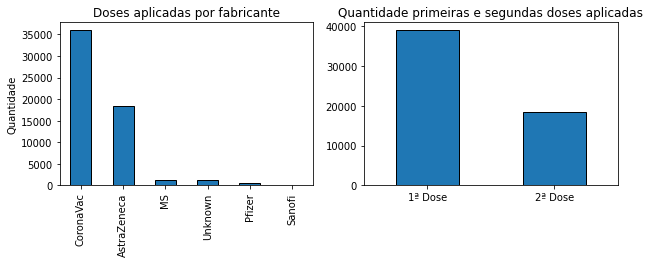

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = dados['vacina_fabricante_nome_n'] \
  .value_counts().plot(kind='bar', ax=axes[0],
                       title="Doses aplicadas por fabricante", 
                       edgecolor='black')
ax.set_ylabel("Quantidade")
ax = dados['vacina_descricao_dose'] \
  .value_counts().plot(kind='bar', ax=axes[1],
                       title="Quantidade primeiras e segundas doses aplicadas",
                       rot=0, edgecolor='black')

ax.set_xticklabels(["1ª Dose", "2ª Dose"])
plt.show()

Nos gráficos acima, podemos ver a distribuição de doses aplicadas, sendo mais de 50% da CoronaVac seguida pela AstraZeneca. A vacinação da Pfizer havia acabado de começar quando os dados foram extraídos.

O gráfico a esquerda compara a quantidade de doses aplicadas entre 1ª e 2ª dose. Essa discrepância pode estar relacionada a vacina da AstraZenica, que possui um intervalo de 3 meses entre a primeira e segunda dose.

Outro problea encontrado é a falta de preenchimento de alguns campos, como "Raça/Cor". Onde 25% dos dados tem "Sem Informação".

In [11]:
dados['paciente_racacor_valor'].value_counts() / len(dados['paciente_racacor_valor']) * 100

BRANCA            37.934576
SEM INFORMACAO    25.993628
PARDA             18.253512
AMARELA           12.656465
PRETA              4.472415
INDIGENA           0.689403
Name: paciente_racacor_valor, dtype: float64

O que leva às mulheres a terem ~60% de vacinação, enquanto que os homents apenas ~40%?

In [12]:
dados['paciente_enumsexobiologico'].value_counts() / len(dados['paciente_enumsexobiologico']) * 100

F    59.212061
M    40.787939
Name: paciente_enumsexobiologico, dtype: float64

## Dados de Vacincação

As datas nos dão uma distribuição no tempo de quantas doses foram aplicadas, porém no formato atual, elas ficam um pouco complicadas de serem trabalhadas. 

Vamos criar uma nova coluna para analisar a distribuição por mês.

In [13]:
dados['vacina_dataaplicacao_mes'] = ["-".join(dt.split('-')[:2])
                                     for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1,CoronaVac,2021-04
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1,Pfizer,2021-05
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1,CoronaVac,2021-03
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04


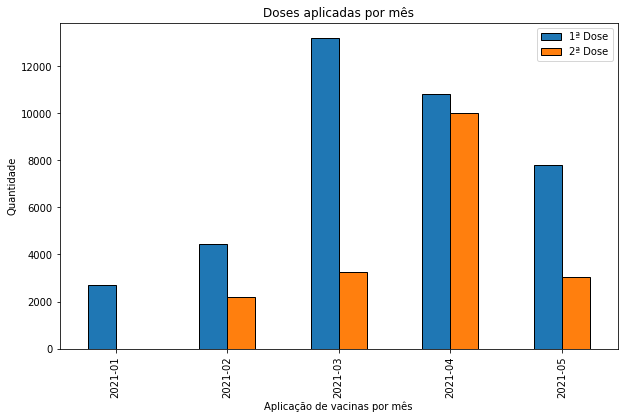

In [14]:
# Há uma vacina aplicada em 03/2020, provavelmente erro de preenchimento
# por isso o [1:]
ax = dados.groupby(['vacina_dataaplicacao_mes','vacina_descricao_dose']) \
  .size().unstack()[1:].plot(kind='bar', edgecolor='black', figsize=(10,6))
# ax = dados.groupby(['vacina_dataaplicacao_mes','vacina_fabricante_nome_n', 'vacina_descricao_dose']) \
#   .size().unstack('vacina_fabricante_nome_n')[1:].plot(kind='bar', edgecolor='black', figsize=(10,6), stacked=True)
ax.set_title("Doses aplicadas por mês")
ax.set_ylabel("Quantidade")
ax.set_xlabel("Aplicação de vacinas por mês")
ax.legend(["1ª Dose", "2ª Dose"])
plt.show()

Temos o inicio da vacinação no Brasil com doses da CoronaVac para os profissionais da saúde, seguido dos idosos. Isso explica o pico de vacinação no mês de Março e o crescimento exponencial da segunda dose em Abril.

Os dados apresentados acima nos dão um bom panorama de quando as vacinas começaram e como estão indo em relação a primeira e segunda dose.

Vamos granuzalizar esses dados por semana.

In [15]:
from datetime import datetime
date_format = '%Y-%m-%d'
dados['vacina_dataaplicacao_semana'] = \
  [datetime.strptime(dt, date_format).isocalendar()[1]
   for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes,vacina_dataaplicacao_semana
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1,CoronaVac,2021-04,14
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04,16
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1,Pfizer,2021-05,18
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1,CoronaVac,2021-03,12
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04,16


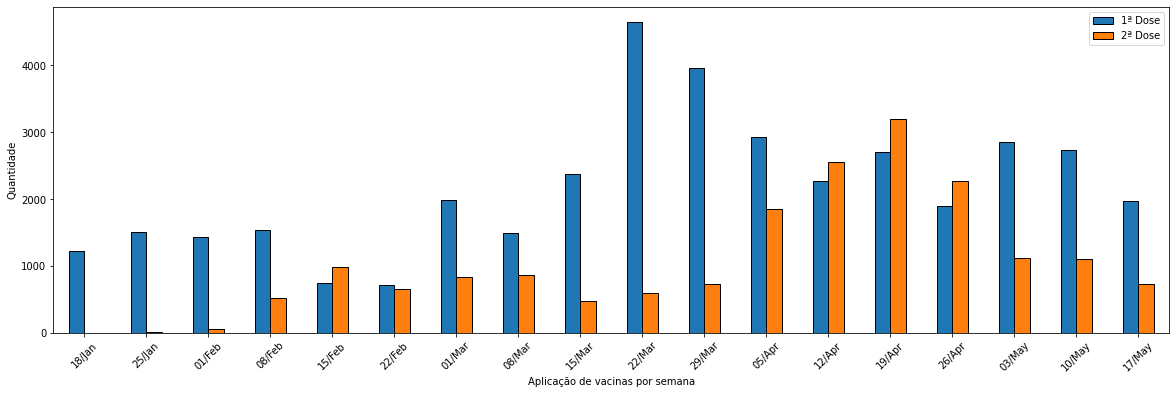

In [16]:
ax = dados.groupby(['vacina_dataaplicacao_semana','vacina_descricao_dose']) \
  .size().unstack().plot(kind='bar', figsize=(20,6), edgecolor='black')
semana_ano = [Week(2021, isoweek).monday().strftime("%d/%b") for isoweek in range(3,21)]
ax.set_xticklabels(semana_ano, rotation=45)
ax.legend(["1ª Dose", "2ª Dose"])
ax.set_xlabel("Aplicação de vacinas por semana")
ax.set_ylabel("Quantidade")
l = ax.get_legend()
plt.show()

Gráfico acima apresenta um resultado similar ao anteiror, exceto que com maior granularidade. Em Abril, podemos ver que há semanas onde a quantidade segundas doses são maiores que as primeiras. Isso de dá pelo pico de vacinação em 22 de Março.

Vacinados por idade com gênero sobrepostos

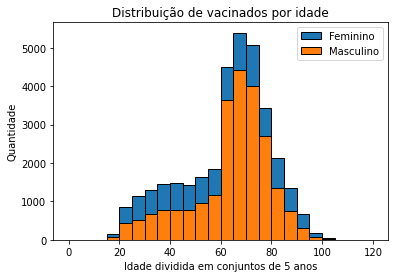

In [17]:
import matplotlib.patches as mpatches
bins_idade = [x for x in range(0,120,5)]
bins_idade.append(120)
ax = dados.groupby('paciente_enumsexobiologico')['paciente_idade'].plot(kind='hist', bins=bins_idade,
                             edgecolor='black',# orientation='horizontal',
                             title="Distribuição de vacinados por idade")
st_shot = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="Feminino")
nd_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="Masculino")
plt.ylabel("Quantidade")
plt.xlabel("Idade dividida em conjuntos de 5 anos")
plt.legend(handles=[st_shot, nd_shot])
plt.show()

Como já haviamos observado, a população femnina é mais vacinada que a masculina.

## Dados de Internação

Vamos inciar a exploração dos dados de internações.



In [18]:
from datetime import datetime
date_format = '%d/%m/%Y'
internacoes['notificacao_semana'] = \
  [datetime.strptime(dt, date_format).isocalendar()[1]
   for dt in internacoes['DT_NOTIFIC']]
internacoes.head()

,DT_NOTIFIC,CS_SEXO,NU_IDADE_N,notificacao_semana
0,05/01/2021,F,46,1
1,04/01/2021,M,3,1
2,04/01/2021,F,84,1
3,04/01/2021,M,65,1
4,08/01/2021,M,16,1


In [19]:
internacoes.groupby('notificacao_semana').size()

notificacao_semana
1     10216
2     26030
3     30277
4     29723
5     30696
6     32150
7     35761
8     44240
9     52289
10    61393
11    68757
12    68499
13    60171
14    57957
15    52758
16    46287
17    45091
18    42601
19    40803
20    32487
21        8
53      173
dtype: int64

A semana 53 são os primeiros dias do ano de 2021, então, estou associando esse valores para a semana 1

In [20]:
internacoes.query("notificacao_semana > 20")

,DT_NOTIFIC,CS_SEXO,NU_IDADE_N,notificacao_semana
41,03/01/2021,F,54,53
46,03/01/2021,M,26,53
6608,03/01/2021,M,81,53
7136,03/01/2021,M,73,53
20919,03/01/2021,M,55,53
...,...,...,...,...
833123,03/01/2021,F,55,53
836331,03/01/2021,M,52,53
840200,03/01/2021,M,50,53
850186,03/01/2021,F,69,53


In [21]:
internacoes.loc[internacoes['notificacao_semana'] > 20, 'notificacao_semana'] = 1

# Vanicação por idade

O Gráfico abaixo mostra a quantidade de pessoas vacinadas por gênero e dose. Vale ressaltar que isso são apenas 0.1% das amostras, a quantidade de vacinados 'real' é 1000 vezes maior.

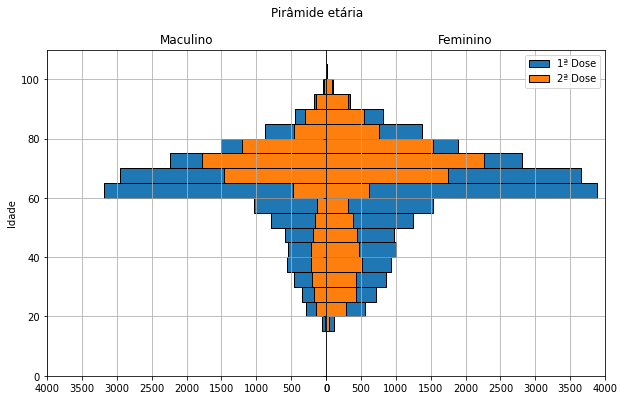

In [22]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
plt.subplots_adjust(wspace=0, hspace=0)
y_lim_sup = 110
y_lim_inf = 0
x_lim_sup = 4000
axes[0].set_xlim(0,x_lim_sup)
axes[1].set_xlim(0,x_lim_sup)
axes[0].set_ylim(y_lim_inf,y_lim_sup)
axes[1].set_ylim(y_lim_inf,y_lim_sup)
axes[0].invert_xaxis()

for group in dados.groupby(['paciente_enumsexobiologico','vacina_descricao_dose']):
  if group[0][0] is 'M':
    idade_maculina = group[1]['paciente_idade']
    ax = idade_maculina.plot(kind='hist', edgecolor='black', bins=bins_idade,
                             orientation='horizontal', ax=axes[0], grid=True,
                             title="Maculino")
    ax.set_xlabel("")
    ax.set_ylabel("Idade")
  if group[0][0] is 'F': # Genero
    idade_feminina = group[1]['paciente_idade']
    ax = idade_feminina.plot(kind='hist', bins=bins_idade, edgecolor='black',
                             orientation='horizontal', ax=axes[1], grid=True,
                             title="Feminino")
    ax.set_yticklabels([])
    ax.set_xlabel("")

st_shot = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="1ª Dose")
nd_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="2ª Dose")
plt.legend(handles=[st_shot, nd_shot])
plt.show()

O gráfico acima demonstra a pirâmide etária dos vacinados por gênero e doses.
Neste gráfico, também fica explicito o maior volume de vacinação no sexo feminino.

## Pirâmide etária

Apesar dessa pirâmide etária acima já contar algumas informações importantes, como a população feminina estar mais vacinada, e a maor quantidade de vacinados em grupos de idade mais alta. Ainda apresenta alguns problemas, como a comparação com a população total.

Dados coletados da pirâmide etária foram adicionados para dar mais um grau de profundidade a análise da vacinação Brasileira.

Fonte: https://www.populationpyramid.net/pt/brasil/2021/

In [23]:
bins_idade = [x for x in range(0,120,5)]
d_bins_f = {}
# Agrupando dados nos bins para o histrograma
for group in dados.groupby(['paciente_enumsexobiologico','vacina_descricao_dose']):
  d_bins_f[f'{group[0][0]}{str(group[0][1])}'] = np.histogram(group[1]['paciente_idade'], bins=bins_idade)[0].tolist()

# Vacinados com idade acima de 100 anos estão sendo agrupados no grupo 99+
for k in d_bins_f:
  first_years = d_bins_f[k][:20]
  first_years.append(sum(d_bins_f[k][20:]))
  d_bins_f[k] = first_years.copy()
df_hist_vac_f = pd.DataFrame()
df_hist_vac_f = df_hist_vac_f.from_dict(d_bins_f)

In [24]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/population_pyramid_brasil_2021.csv" .
pir_etaria = pd.read_csv("/content/population_pyramid_brasil_2021.csv")
df_hist_vac = pd.DataFrame()
df_hist_vac = df_hist_vac.from_dict(d_bins_f)
df_piramide = pd.concat([pir_etaria, df_hist_vac], axis=1)
# Como extraimos 0.1%, vamos multiplicar por mil as vacinas já aplicadas
# Porem! Vamos dividir por milhão para simplificar os eixos do gráfico!
df_piramide['M1']  = df_piramide['M1']/1000.0
df_piramide['F1']  = df_piramide['F1']/1000.0
df_piramide['M2']  = df_piramide['M2']/1000.0
df_piramide['F2']  = df_piramide['F2']/1000.0
df_piramide['F']  = df_piramide['F']/10**6
df_piramide['M']  = df_piramide['M']/10**6
df_piramide.head()

,Age,M,F,F1,F2,M1,M2
0,0-4,7.357796,7.027050,0.000,0.000,0.001,0.000
1,5-9,7.456918,7.126488,0.000,0.000,0.000,0.000
2,10-14,7.550011,7.244662,0.000,0.000,0.000,0.000
3,15-19,8.110694,7.827868,0.109,0.045,0.064,0.013
4,20-24,8.630334,8.410568,0.557,0.285,0.294,0.144


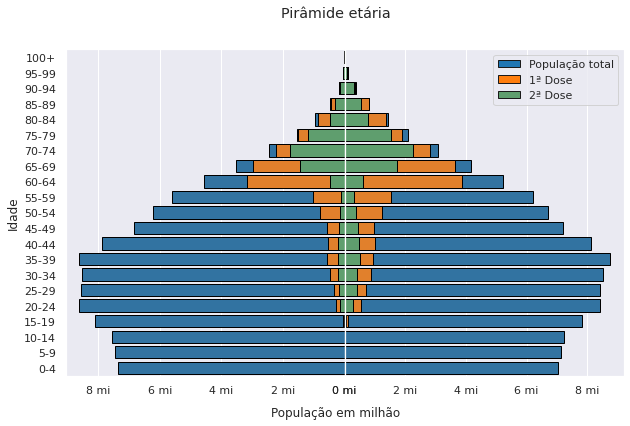

In [25]:
import seaborn as sns
sns.set_theme()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
fig.text(0.5, 0.04, 'População em milhão', ha='center', va='center')
plt.subplots_adjust(wspace=0, hspace=0)
axes[0].invert_xaxis()

sns.barplot(x="M",y="Age", color="#1f76b4", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M2",y="Age", color="g", data = df_piramide, ax=axes[0], edgecolor='black')

sns.barplot(x="F",y="Age", color="#1f76b4", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F2",y="Age", color="g", data = df_piramide, ax=axes[1], edgecolor='black')

axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[1].set_yticklabels([])
axes[0].set_ylabel("Idade")
axes[1].set_ylabel("")
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))
axes[1].tick_params(left=False)

pop = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="População total")
st_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="1ª Dose")
nd_shot = mpatches.Patch(facecolor='#5f9e6e', edgecolor='k', label="2ª Dose")
plt.legend(handles=[pop, st_shot, nd_shot])

Com o gráfico acima, vemos a distribuição de vacinados na população total. É possível notar que a população acima de 70 anos tem uma boa cobertura. E que de 60 a 70 temos um avanço muito grande.

Outro detalhe, é a distribuição de vacinas nos grupos mais jovens. Seja por serem profissionais da saúde ou pessoas com comorbidades.

In [26]:
bins_idade = [x for x in range(0,120,20)]
hist_por_semana_por_idade_vac = {}
hist_por_semana_por_idade_vac['Age'] = [f'{bins_idade[bin]}-{bins_idade[bin+1]-1}' for bin in range(len(bins_idade)-1)]

for group in dados.query("vacina_descricao_dose == '1'").groupby(['vacina_dataaplicacao_semana']):
  hist_por_semana_por_idade_vac[group[0]] = np.histogram(group[1]['paciente_idade'], bins=bins_idade)[0].tolist()
df_hist_semana_por_idade_vac = pd.DataFrame()
df_hist_semana_por_idade_vac = df_hist_semana_por_idade_vac.from_dict(hist_por_semana_por_idade_vac)
df_hist_semana_por_idade_vac = df_hist_semana_por_idade_vac.set_index('Age')
df_hist_semana_por_idade_vac = df_hist_semana_por_idade_vac*1000
df_hist_semana_por_idade_vac.head()

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Age,,,,,,,,,,,,,,,,,,
0-19,16000,7000,7000,13000,7000,7000,5000,2000,3000,5000,9000,13000,4000,5000,8000,23000,22000,18000
20-39,594000,674000,527000,302000,111000,76000,103000,96000,95000,168000,172000,220000,152000,123000,136000,341000,427000,412000
40-59,445000,565000,431000,244000,104000,59000,115000,58000,71000,131000,154000,349000,299000,240000,340000,858000,1833000,1420000
60-79,115000,155000,143000,175000,70000,77000,711000,855000,1975000,4236000,3578000,2316000,1802000,2312000,1405000,1633000,440000,113000
80-99,45000,101000,314000,801000,446000,488000,1049000,483000,222000,104000,41000,31000,17000,22000,7000,4000,7000,5000


## Vacinação por semana

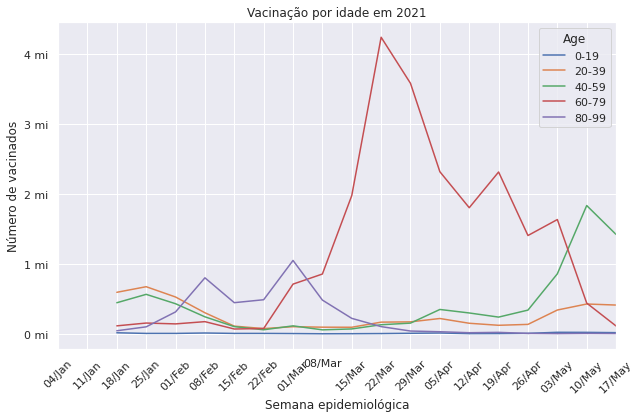

In [27]:
df_hist_semana_por_idade_vac_p = df_hist_semana_por_idade_vac / 10**6
ax = df_hist_semana_por_idade_vac_p.T.plot(figsize=(10,6), grid=True)
ax.set_xlim(1,20)
semana_ano = [Week(2021, isoweek).monday().strftime("%d/%b") for isoweek in range(1,21)]
ax.set_xticklabels(semana_ano, rotation=45)
plt.xticks(np.arange(1, 21, 1.0))
ax.set_xlabel("Semana epidemiológica")
ax.set_ylabel("Número de vacinados")
ax.set_title("Vacinação por idade em 2021")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))
plt.show()

No gráfico acima, temos a quantidade de vacinados por grupos de 20 anos semana a semana. É notável no início da vacinação a mistura dos grupos de idades, isso ocorre porque inicio-se pelos profissionais da saúde. Após este grupo, o grupo dos idosos 80+ começou. E na semana de 8 de março inicio o grupo 60+.

# Internação por Idade



In [28]:
bins_idade = [x for x in range(0,120,20)]

hist_por_semana_por_idade = {}
hist_por_semana_por_idade['Age'] = [f'{bins_idade[bin]}-{bins_idade[bin+1]-1}' for bin in range(len(bins_idade)-1)]

for group in internacoes.groupby(['notificacao_semana']):
  hist_por_semana_por_idade[group[0]] = np.histogram(group[1]['NU_IDADE_N'], bins=bins_idade)[0].tolist()
df_hist_semana_por_idade = pd.DataFrame()
df_hist_semana_por_idade = df_hist_semana_por_idade.from_dict(hist_por_semana_por_idade)
df_hist_semana_por_idade = df_hist_semana_por_idade.set_index('Age')
df_hist_semana_por_idade.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Age,,,,,,,,,,,,,,,,,,,,
0-19,1280,2163,2168,2153,2219,2338,2622,2992,2997,3280,3418,3183,2748,2882,2860,2568,2669,2605,2863,2054
20-39,1119,2892,3258,3245,3610,4073,4752,5980,7078,8197,8981,9005,7799,7745,7085,6461,6637,6659,6632,5550
40-59,2222,6886,8373,8367,8894,9597,10878,14042,17403,20789,23615,23633,20992,20048,18379,16726,16810,16675,16712,13964
60-79,3698,9858,11685,11340,11155,11571,12805,15772,18695,22583,25578,26053,23326,22258,20052,16807,15200,13179,11378,8346
80-99,2061,4199,4751,4574,4778,4545,4670,5405,6068,6507,7125,6589,5262,4986,4345,3703,3752,3459,3184,2547


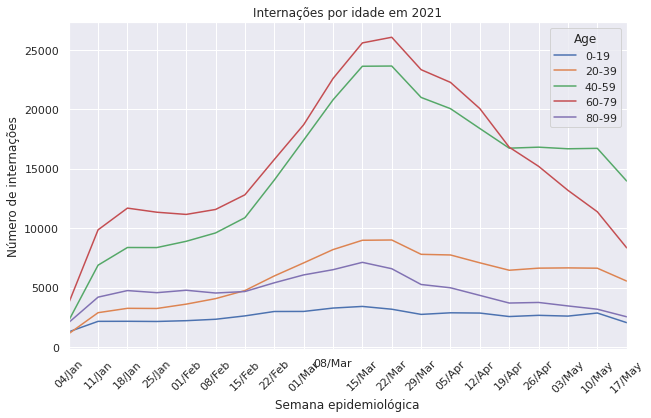

In [29]:
ax = df_hist_semana_por_idade.T.plot(figsize=(10,6), grid=True)
ax.set_xlim(1,20)
semana_ano = [Week(2021, isoweek).monday().strftime("%d/%b") for isoweek in range(1,21)]
ax.set_xticklabels(semana_ano, rotation=45)
plt.xticks(np.arange(1, 21, 1.0))
ax.set_xlabel("Semana epidemiológica")
ax.set_ylabel("Número de internações")
ax.set_title("Internações por idade em 2021")
plt.show()

Podemos observar no gráfico acima a curva de internações da segunda onda do COVID-19 no Brasil por idade. Os dados foram agrupados em conjuntos de 20 anos para simplificar a leitura.

Um ponto interessante é que em Março houve o pico de internações, seguido de uma queda dada as medidas de isolamento social pelo País. Mas, após o arrefecimento das contiaminações e internações, as medidas de isolamento foram sendo abrandadas e isso pode ser observado apartir da semana 19 de Abril.

Apartir de 19 de Abril, as internações entram em um platô para todas as idades, exceto maiores de 60 anos! Isso se dá pelo estado atual de cobertura da vacinação para esse grupo.

# Vacinação x Internação

In [30]:
grupo_60_mais_vac = df_hist_semana_por_idade_vac.T['60-79'] + df_hist_semana_por_idade_vac.T['80-99']
grupo_60_mais_vac_acum = [0,0]
acum = 0
for semana in grupo_60_mais_vac:
  acum += semana
  grupo_60_mais_vac_acum.append(acum)
grupo_60_mais_hosp = df_hist_semana_por_idade.T['60-79'] + df_hist_semana_por_idade.T['80-99']
grupo_60_mais_hosp = grupo_60_mais_hosp.tolist()
dict_60_mais = {'Hospitalizados' : grupo_60_mais_hosp,
                'Vacinados' : grupo_60_mais_vac_acum}
df_60_mais = pd.DataFrame()
df_60_mais = df_60_mais.from_dict(dict_60_mais)
df_60_mais = df_60_mais.set_index(df_hist_semana_por_idade.T.index)
df_60_mais['Vacinados'] = df_60_mais['Vacinados']/10**6
pop_total_60_mais = pir_etaria[12:][['M', 'F']].sum().sum()/10**6

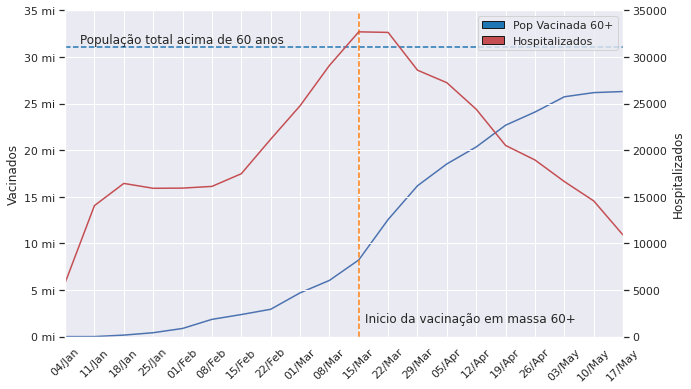

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.xticks(np.arange(1, 21, 1.0))
sns.set_theme()

ax1 = sns.lineplot(x=df_60_mais['Vacinados'].index, y=df_60_mais['Vacinados'], data=df_60_mais['Vacinados'], ax=axes)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))
ax1.set_ylim(0,35)  # TODO Add line of 100% vacinated
ax1.text(1.5, 31.5, "População total acima de 60 anos")
ax1.axhline(pop_total_60_mais, ls='--', color='#1f76b4')
ax1.text(11.2, 1.5, "Inicio da vacinação em massa 60+")
ax1.axvline(11, ls='--', color='#ff7e0e')
ax1.set_xticklabels(semana_ano, rotation=45)
ax2 = ax1.twinx()
sns.lineplot(x=df_60_mais['Hospitalizados'].index, y=df_60_mais['Hospitalizados'], data=df_60_mais['Hospitalizados'], ax=ax2, color='r')
ax2.set_ylim(0,35000)
ax2.set_xlim(1,20)

pop = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="Pop Vacinada 60+")
hosp = mpatches.Patch(facecolor='r', edgecolor='k', label="Hospitalizados")
# target_60_mais = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="",ls='--')
plt.legend(handles=[pop, hosp])
plt.show()

Observando os dados de vacinação e hospitalizações, podemos ver uma relação entre o momento em que as vacinações no grupo 60+ se inciam em massa e o número de internação dessa população caindo.

# Conclusão

A vacinação é um instrumento poderosíssimo contra a COVID-19. Isto, aliado a medidas de prevencão como distanciamento, máscara e higienização, podemos evitar ainda mais mortes.

Se puder, fique em casa.